## ПРОВЕРКА АДЕКВАТНОСТИ МОДЕЛИ РЕГРЕССИИ ПО ОСТАТКАМ
### Вариант - 3

In [1]:
#TODO: пока что представлено решение для уравнения регрессии из ЛР55, сделать то же самое для лабораторной работы 3 

In [37]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

В ходе выполнения лабораторной работы 5 получили следующее уравнение множественной регрессии: `y = 0.5259 * x1 + 0.1592 * x2 + 2.0509`

### Считываем набор данных для третьего варианта

In [96]:
def lr_predict(
    data: pd.DataFrame,
    x1_column_name: str = 'x1',
    x2_column_name: str = 'x2'
    ) -> list[float]:
    x1, x2 = data[x1_column_name], data[x2_column_name]
    predict = 0.5259 * x1 + 0.1592 * x2 + 2.0509
    return predict

In [97]:
def get_residuals(
    data: pd.DataFrame,
    x1_column_name: str = 'x1',
    x2_column_name: str = 'x2',
    target_column_name: str = 'y'
    ) -> list[float]:
    targets = data[target_column_name]
    residuals = targets - lr_predict(data, x1_column_name, x2_column_name)
    return residuals

In [98]:
df = pd.read_excel('../LR_5/v3_table.xlsx')

In [99]:
df.head()

,x1,x2,x3,y
0,48,44,47,34
1,57,35,56,35
2,55,39,54,38
3,61,43,62,39
4,56,36,56,41


In [100]:
df = df.drop(columns=['x3']) # Так как исключили `x3` в силу высокой скореллированности с `x1`

In [101]:
df.head()

,x1,x2,y
0,48,44,34
1,57,35,35
2,55,39,38
3,61,43,39
4,56,36,41


In [102]:
residuals = get_residuals(
    df,
    x1_column_name='x1',
    x2_column_name='x2',
    target_column_name='y'
)

In [103]:
residuals # список остатков при запуске модели на загруженных данных

0    -0.2989
1    -2.5992
2     0.8158
3    -1.9764
4     3.7675
5     0.9753
6    -0.9761
7     0.6089
8    -0.2316
9     0.3789
10    1.0192
11    0.8044
12    1.5518
13   -3.8184
dtype: float64

Text(0.5, 1.0, 'График остатков для построенной модели множественной регрессии')

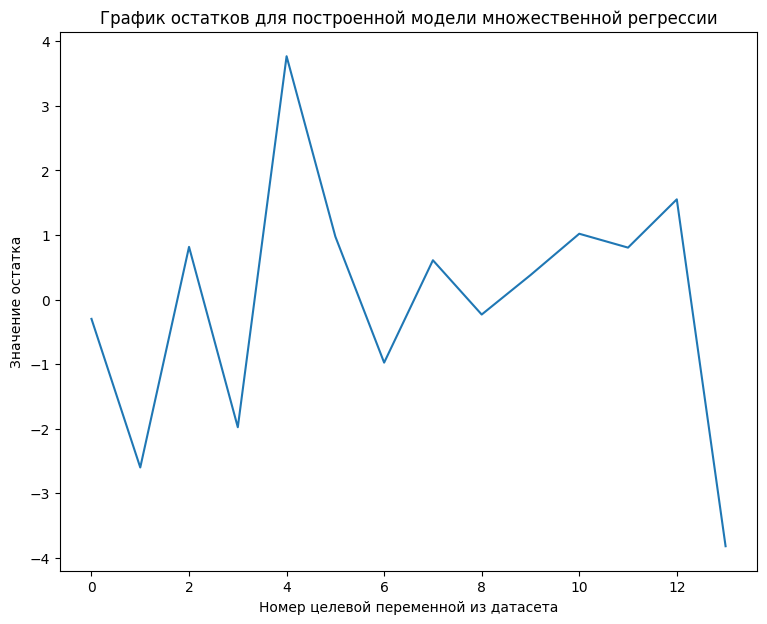

In [104]:
plt.figure(figsize=(9, 7))
plt.plot(residuals)
plt.xlabel('Номер целевой переменной из датасета')
plt.ylabel('Значение остатка')
plt.title('График остатков для построенной модели множественной регрессии')

### Проверка 1. Уровни ряда остатков имеют случайный характер.

#### Посчитаем число поворотных точек
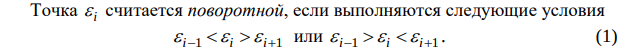

In [88]:
turning_points = 0
for i in range(1, len(residuals) - 1):
    if (residuals[i - 1] < residuals[i] and residuals[i] > residuals[i + 1]) \
        or (residuals[i - 1] > residuals[i] and residuals[i] < residuals[i + 1]):
        turning_points += 1
print(f'Число поворотных точек: {turning_points}')
print(f'Общее количество наболюдений в выборке: {len(residuals)}')


Число поворотных точек: 10
Общее количество наболюдений в выборке: 14


Далее подсчитывается число поворотных точек p. Критерием случайности с
5%-ным уровнем значимости, т.е. с доверительной вероятностью 95%,
является выполнение равенства
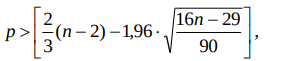

In [89]:
10 > (2/3 * ((len(residuals) - 2)) - 1.96 * math.sqrt((16 * len(residuals)) - 29) / 90)

True

**Вывод**: поскольку неравенство выполняется, то составленное уравнение линейной регрессии адекватно

### Проверка 2. Уровни ряда остатков имеют случайный характер.

Для проверки равенства математического ожидания остаточной
последовательности нулю вычисляется среднее значение ряда остатков

In [90]:
residuals_mean = np.mean(residuals)
residuals_mean

0.001514285714284469

Поскольку среднее значение остатков модели регрессии примерно равно нулю с точностью до 3-го знака, то можно считать, что модель не содержит постоянной систематической
ошибки и адекватна по критерию нулевого среднего. 

### Проверка 3. Значения остатков независимы друг от друга, т.е. отсутствует автокорреляция.

Проверку независимости последовательности остатков (отсутствие
автокорреляции) осуществляют с помощью d-критерия Дарбина-Уотсона. 

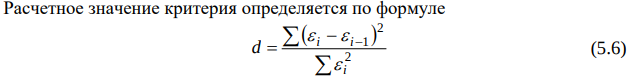

In [105]:
def get_durbin_watson_statistic(residuals: list[float]) -> float:
    sum_of_squares_of_residuals = sum([res ** 2 for res in residuals])
    squared_diff = 0
    for i in range(1, len(residuals)):
        squared_diff += (residuals[i] - residuals[i - 1]) ** 2
    return squared_diff / sum_of_squares_of_residuals

In [106]:
d1 = 0.66 # Нижняя граница значения критерий Дарбина-Уотсона для 14-ти наблюдений в выборке
d2 = 1.254 # Верхняя граница значения критерий Дарбина-Уотсона для 14-ти наблюдений в выборке

In [93]:
def durbin_watson_criterion(
        d: float,
        d1: float,
        d2: float) -> str:
        d_w_statistic = d
        if d_w_statistic < d1:
                return 'Гипотеза о независимости остатков отвергается, и модель признается неадекватной по критерию независимости остатков.'
        elif d1 < d_w_statistic < d2:
                return 'Нет достаточных оснований делать тот или иной вывод.'
        elif d2 < d_w_statistic < 2:
                return 'Гипотеза о независимости остатков принимается и модель признается адекватной по данному критерию.'
        elif d_w_statistic > 2:
                d_w_statistic = 4 - d_w_statistic
                return durbin_watson_criterion(d_w_statistic, d1, d2)
                

In [94]:
d = get_durbin_watson_statistic(
    residuals=residuals
)
d

2.1984293258604435

In [95]:
durbin_watson_criterion(
    d=d,
    d1=d1,
    d2=d2
)

'Гипотеза о независимости остатков принимается и модель признается адекватной по данному критерию.'